In [1]:
import os

fname = 'jena_climate_2009_2016.csv'

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))


['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [2]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [3]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)
plt.show()

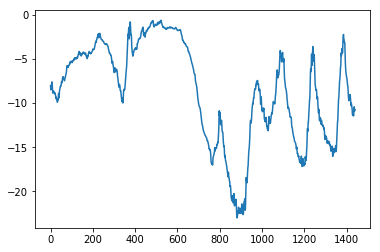

In [4]:
plt.plot(range(1440), temp[:1440])
plt.show()

In [5]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [6]:
def generator(data, lookback, delay, min_index, max_index,
        shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [7]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step,
    batch_size=batch_size)
val_gen = generator(float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)
test_gen = generator(float_data,
    lookback=lookback,
    delay=delay,
    min_index=300001,
    max_index=None,
    step=step,
    batch_size=batch_size)

val_steps = (300000 - 200001 - lookback)

test_steps = (len(float_data) - 300001 - lookback)

In [16]:
print(next(train_gen)[0].shape)
print(float_data.shape)

(128, 240, 14)
(420551, 14)


In [8]:
val_steps = 2000

# Naive method

In [11]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2888970002638613


In [11]:
0.28969941979609765*std[1]

2.5645638478601653

# Simple DL method

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
    steps_per_epoch=500,
    epochs=20,
    validation_data=val_gen,
    validation_steps=val_steps)

In [ ]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [9]:
float_data.shape

(420551, 14)

# Recurrent

In [12]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
    steps_per_epoch=500,
    epochs=20,
    validation_data=val_gen,
    validation_steps=val_steps)

Q:\Program Files\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Epoch 1/20
500/500 [==============================] - 162s 324ms/step - loss: 0.3002 - val_loss: 0.2713
Epoch 2/20
500/500 [==============================] - 161s 321ms/step - loss: 0.2834 - val_loss: 0.2655
Epoch 3/20
500/500 [==============================] - 161s 321ms/step - loss: 0.2775 - val_loss: 0.2651
Epoch 4/20
500/500 [==============================] - 160s 321ms/step - loss: 0.2699 - val_loss: 0.2630
Epoch 5/20
500/500 [==============================] - 161s 322ms/step - loss: 0.2682 - val_loss: 0.2638
Epoch 6/20
500/500 [==============================] - 160s 321ms/step - loss: 0.2622 - val_loss: 0.2709
Epoch 7/20
500/500 [==============================] - 160s 321ms/step - loss: 0.2576 - val_loss: 0.2667
Epoch 8/20
500/500 [==============================] - 161s 322ms/step - loss: 0.2545 - val_loss: 0.2730
Epoch 9/20
500/500 [==============================] - 161s 322ms/step - loss: 0.2496 - val_loss: 0.2721
Epoch 10/20
500/500 [==============================] - 161s 321m

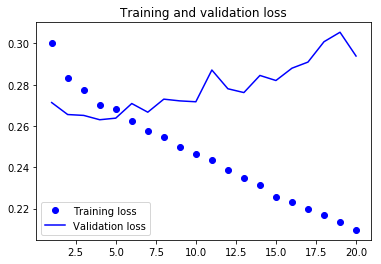

In [13]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Training and evaluating a dropout-regularized, stacked GRU model

In [14]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
    dropout=0.1,
    recurrent_dropout=0.5,
    return_sequences=True,
    input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
    dropout=0.1,
    recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
    steps_per_epoch=500,
    epochs=40,
    validation_data=val_gen,
    validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 376s 752ms/step - loss: 0.3330 - val_loss: 0.2777
Epoch 2/40
500/500 [==============================] - 377s 755ms/step - loss: 0.3099 - val_loss: 0.2706
Epoch 3/40
500/500 [==============================] - 375s 749ms/step - loss: 0.3060 - val_loss: 0.2722
Epoch 4/40
500/500 [==============================] - 379s 757ms/step - loss: 0.2997 - val_loss: 0.2686
Epoch 5/40
500/500 [==============================] - 387s 775ms/step - loss: 0.2965 - val_loss: 0.2640
Epoch 6/40
500/500 [==============================] - 384s 767ms/step - loss: 0.2964 - val_loss: 0.2679
Epoch 7/40
500/500 [==============================] - 382s 764ms/step - loss: 0.2910 - val_loss: 0.2670
Epoch 8/40
500/500 [==============================] - 380s 759ms/step - loss: 0.2877 - val_loss: 0.2634
Epoch 9/40
500/500 [==============================] - 379s 758ms/step - loss: 0.2852 - val_loss: 0.2790
Epoch 10/40
500/500 [==============================] - 382s 764m

KeyboardInterrupt: 

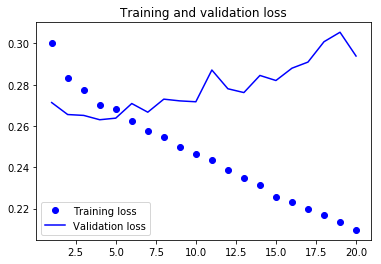

In [15]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()